# Fine-Tuning `VGGNet` with `keras`

This notebook demonstrates how to create a single pipeline to resize, preprocess, and augment images in real time during training with `keras`. This eliminates the need to preprocess images and write them back to disk before doing fine-tuning. This is accomplished by hooking together `keras.preprocessing.image.ImageDataGenerator` with `keras.applications.vgg16.preprocess_input()` via the former's (undocumented) `preprocessing_function` argument with a small wrapper function.  

This notebook modifies [this tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) (full code [here](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)).

This approach can be generalized to all keras [pretrained models](https://keras.io/applications/). For example, for `keras.applications.resnet50.ResNet50`, you would simply swap out `keras.applications.vgg16.preprocess_input()` for `keras.applications.resnet50.preprocess_input()`.

### Prerequisites

This code assumes you have downloaded the kaggle [cats vs. dogs](https://www.kaggle.com/c/dogs-vs-cats) dataset and have the following directory setup.

```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```

---

# Load `VGGNet`

In [1]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense

vgg16 = VGG16(weights='imagenet')
vgg16.summary()

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Replace Final Dense Layer

In [2]:
fc2 = vgg16.get_layer('fc2').output
p = Dense(output_dim=1, activation='sigmoid', name='logit')(fc2)
model = Model(input=vgg16.input, output=p)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", name="logit", units=1)`
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("lo...)`
  This is separate from the ipykernel package so we can avoid doing imports until


# Freeze All Layers Except Bottleneck Layers for Fine-Tuning

In [3]:
import pandas as pd

for layer in model.layers:
    if layer.name in ['fc1', 'fc2', 'logit']:
        continue
    layer.trainable = False

df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"white" if trainable else "lightblue"}', subset=['trainable'])

,layer,trainable
0,input_1,False
1,block1_conv1,False
2,block1_conv2,False
3,block1_pool,False
4,block2_conv1,False
5,block2_conv2,False
6,block2_pool,False
7,block3_conv1,False
8,block3_conv2,False
9,block3_conv3,False


# Compile with `SGD` Optimizer and a Small Learning Rate

In [4]:
from keras.optimizers import SGD

sgd = SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Set Up Data Generators

Note the use of the `preprocessing_function` argument in `keras.preprocessing.image.ImageDataGenerator`.

In [5]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img

def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    from keras.applications.vgg16 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='data/train',
                                                    target_size=[224, 224],
                                                    batch_size=16,
                                                    class_mode='binary')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
validation_generator = validation_datagen.flow_from_directory(directory='data/test',
                                                              target_size=[224, 224],
                                                              batch_size=16,
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


# Do Fine-Tuning

Since fine-tuning `VGGNet` is slow, we only perform a single epoch of training.

In [6]:
model.fit_generator(train_generator,
                    steps_per_epoch=16,
                    epochs=1,
                    validation_data=validation_generator,
                    validation_steps=32);

Epoch 1/1
16/16 [==============================] - 234s 15s/step - loss: 0.5591 - acc: 0.7500 - val_loss: 0.1371 - val_acc: 0.9533


# Show Some Predictions

Note that the images look a little weird because their mean RGB values have been subtracted away.

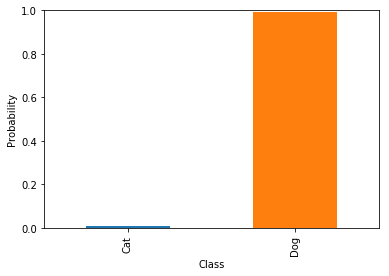

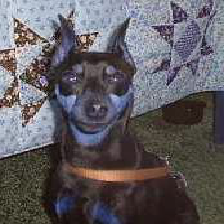

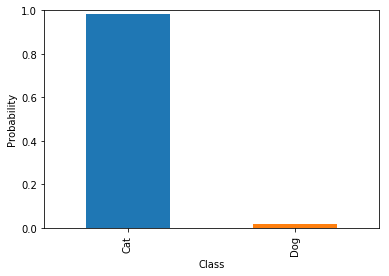

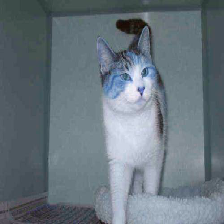

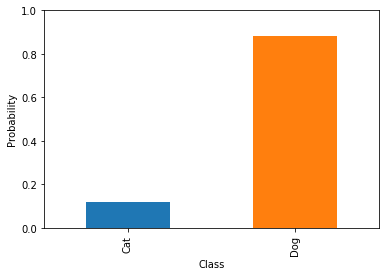

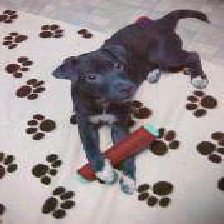

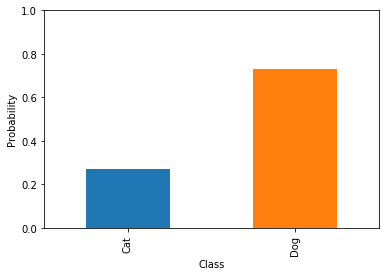

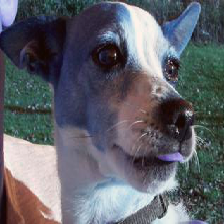

In [9]:
from IPython.display import display
import matplotlib.pyplot as plt

X_val_sample, _ = next(validation_generator)
y_pred = model.predict(X_val_sample)

nb_sample = 4
for x, y in zip(X_val_sample[:nb_sample], y_pred.flatten()[:nb_sample]):
    s = pd.Series({'Cat': 1-y, 'Dog': y})
    axes = s.plot(kind='bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Probability')
    axes.set_ylim([0, 1])
    plt.show()

    img = array_to_img(x)
    display(img)